Configuration & Path Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



# 1. Dynamic Path Setup
current_dir = os.getcwd()
project_root = current_dir

# Climb up until we find 'src'
while not os.path.exists(os.path.join(project_root, 'src')):
    parent = os.path.dirname(project_root)
    if parent == project_root:
        raise FileNotFoundError("Could not find 'src'. Are you in the project folder?")
    project_root = parent

if project_root not in sys.path:
    sys.path.append(project_root)

DATA_PATH = os.path.join(project_root, 'data')
print(f"Project Root: {project_root}")
print(f"Data Path:    {DATA_PATH}")

# 2. Import Custom Modules

from src.data_loader_tx import ClinicalTrialLoader
from src.preprocessing_tx import get_pipeline


Project Root: /home/delaunan/code/delaunan/clintrialpredict
Data Path:    /home/delaunan/code/delaunan/clintrialpredict/data


 Smart Data Loading (Auto-Generation)

In [4]:
CSV_PATH = os.path.join(DATA_PATH, 'project_data.csv')
FORCE_REGENERATE = False  # Set to True if you changed code in data_loader.py

if os.path.exists(CSV_PATH) and not FORCE_REGENERATE:
    print(f">>> Loading existing dataset from: {CSV_PATH}")
    df = pd.read_csv(CSV_PATH)
else:
    print(">>> File not found (or forced regeneration). Triggering ETL pipeline...")
    loader = ClinicalTrialLoader(data_path=DATA_PATH)

    # 1. Load & Clean
    df = loader.load_and_clean()

    # 2. Add Features (Hierarchy, Competition, Text)
    df = loader.add_features(df)

    # 3. Save
    loader.save(df, filename='project_data.csv')

print(f"Data Ready. Shape: {df.shape}")

>>> Loading existing dataset from: /home/delaunan/code/delaunan/clintrialpredict/data/project_data.csv
Data Ready. Shape: (67363, 136)


Temporal Split (Time Travel) <br>
Why: We sort by date to ensure strict separation of Past (Train) and Future (Test).

In [5]:
# ----------------------------------------------------------------------------------
# TEMPORAL SPLIT & STATISTICS REPORT
# ----------------------------------------------------------------------------------

# 1. Sort by Date to ensure we predict the future from the past
df = df.sort_values('start_year').reset_index(drop=True)

# 2. Define Split Point (e.g., 80% Train, 20% Test)
split_idx = int(len(df) * 0.80)

train_df = df.iloc[:split_idx].copy()
test_df = df.iloc[split_idx:].copy()

# 3. Define Features & Target
target_col = 'target'
drop_cols = [target_col, 'overall_status', 'nct_id']

X_train = train_df.drop(columns=drop_cols)
y_train = train_df[target_col]

X_test = test_df.drop(columns=drop_cols)
y_test = test_df[target_col]

# ----------------------------------------------------------------------------------
# PRINT STATISTICS
# ----------------------------------------------------------------------------------
def print_stats(name, dataset, y):
    n_total = len(dataset)
    n_good = len(dataset[y == 0]) # 0 = Completed
    n_bad = len(dataset[y == 1])  # 1 = Terminated/Withdrawn

    pct_good = (n_good / n_total) * 100
    pct_bad = (n_bad / n_total) * 100

    min_year = dataset['start_year'].min()
    max_year = dataset['start_year'].max()

    print(f"--- {name} SET ---")
    print(f"Time Period:   {int(min_year)} to {int(max_year)}")
    print(f"Total Trials:  {n_total}")
    print(f"Good (0):      {n_good} ({pct_good:.1f}%)")
    print(f"Bad (1):       {n_bad} ({pct_bad:.1f}%)")
    print("")

print("="*40)
print("DATASET SPLIT STATISTICS")
print("="*40)

# Overall
print_stats("OVERALL", df, df[target_col])

# Training
print_stats("TRAINING (Past)", train_df, y_train)

# Testing
print_stats("TESTING (Future)", test_df, y_test)

print("="*40)
print(f"Split Ratio: {len(train_df)/len(df):.0%} Train / {len(test_df)/len(df):.0%} Test")

DATASET SPLIT STATISTICS
--- OVERALL SET ---
Time Period:   2000 to 2015
Total Trials:  67363
Good (0):      56414 (83.7%)
Bad (1):       10949 (16.3%)

--- TRAINING (Past) SET ---
Time Period:   2000 to 2013
Total Trials:  53890
Good (0):      45441 (84.3%)
Bad (1):       8449 (15.7%)

--- TESTING (Future) SET ---
Time Period:   2013 to 2015
Total Trials:  13473
Good (0):      10973 (81.4%)
Bad (1):       2500 (18.6%)

Split Ratio: 80% Train / 20% Test


dummy classifier (basline assessment)

In [6]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("--- BASELINE: DUMMY CLASSIFIER ---")

# 1. Create & Fit (Strategy: Always predict the majority class)

dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)

# 2. Predict
y_pred_dummy = dummy.predict(X_test)

# 3. Basic Metrics
print(f"Accuracy:  {accuracy_score(y_test, y_pred_dummy):.4f}")
# Note: Precision/Recall will likely be 0.0 if the majority class is 0 (Completed)
print(f"Precision: {precision_score(y_test, y_pred_dummy, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_dummy):.4f}")
print("\nInterpretation: This is the score you get by doing absolutely nothing.")

--- BASELINE: DUMMY CLASSIFIER ---
Accuracy:  0.8144
Precision: 0.0000
Recall:    0.0000

Interpretation: This is the score you get by doing absolutely nothing.


Model training

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# 1. Build Pipeline
model = Pipeline(steps=[
    ('preprocessor', get_pipeline()),
    ('classifier', LogisticRegression(
        class_weight='balanced', # This handles Class 0 vs Class 1 balance automatically
        solver='liblinear',
        penalty='l2',
        C=0.01,
        max_iter=1000,
        random_state=42
    ))
])

# 2. Fit WITHOUT Phase Weights
print(f"Training Logistic Regression on {len(X_train)} trials...")

model.fit(X_train, y_train)

print("Training Complete.")


Training Logistic Regression on 53890 trials...
Training Complete.


Evaluation & Visualization

--- MODEL PERFORMANCE METRICS ---
ROC-AUC Score:      0.6959  (0.5 = Random, 1.0 = Perfect)
PR-AUC Score:       0.3207   (Baseline: 0.1856)
----------------------------------------
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.92      0.41      0.57     10973
           1       0.25      0.85      0.38      2500

    accuracy                           0.49     13473
   macro avg       0.59      0.63      0.48     13473
weighted avg       0.80      0.49      0.53     13473



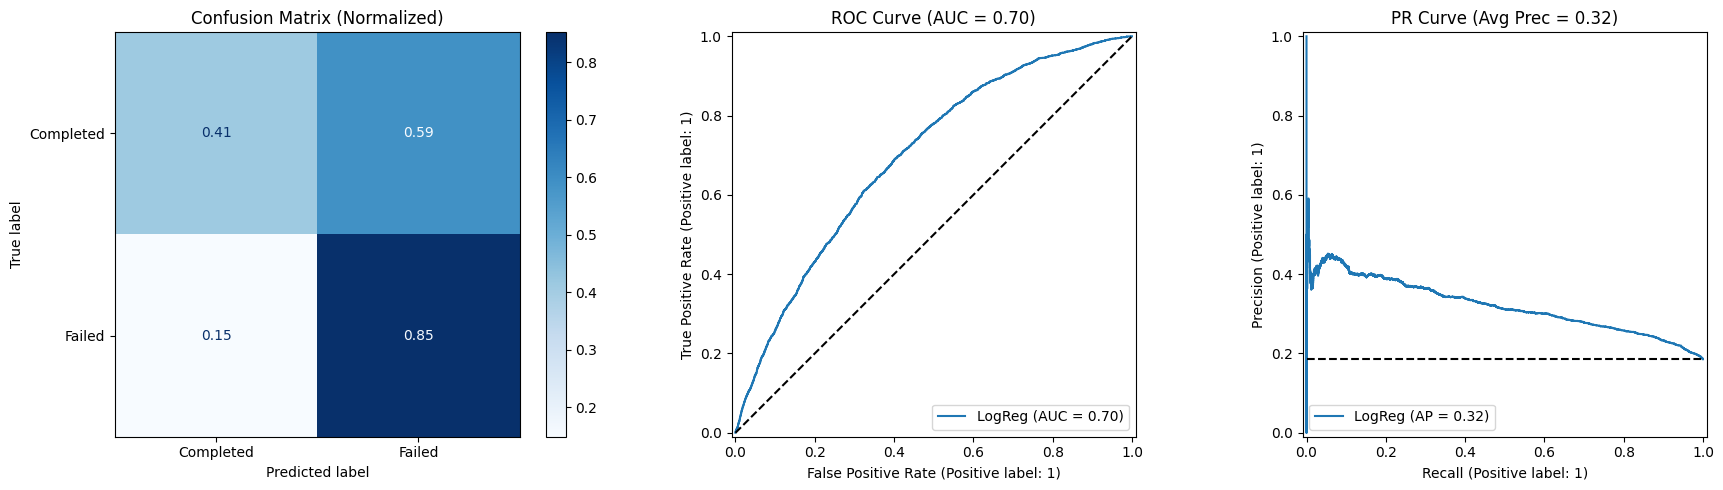

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    classification_report,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay)

# 1. Get Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# 2. Calculate Advanced Metrics
roc_score = roc_auc_score(y_test, y_prob)
pr_score = average_precision_score(y_test, y_prob)

print(f"--- MODEL PERFORMANCE METRICS ---")
print(f"ROC-AUC Score:      {roc_score:.4f}  (0.5 = Random, 1.0 = Perfect)")
print(f"PR-AUC Score:       {pr_score:.4f}   (Baseline: {y_test.mean():.4f})")
print("-" * 40)
print("CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred))

# 3. Visualizations
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# A. Confusion Matrix (Normalized)
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    normalize='true',
    cmap='Blues',
    display_labels=['Completed', 'Failed'],
    ax=ax[0]
)
ax[0].set_title("Confusion Matrix (Normalized)")

# B. ROC Curve
RocCurveDisplay.from_predictions(y_test, y_prob, ax=ax[1], name='LogReg')
ax[1].set_title(f"ROC Curve (AUC = {roc_score:.2f})")
ax[1].plot([0, 1], [0, 1], "k--", label="Chance")

# C. Precision-Recall Curve
PrecisionRecallDisplay.from_predictions(y_test, y_prob, ax=ax[2], name='LogReg')
ax[2].set_title(f"PR Curve (Avg Prec = {pr_score:.2f})")
ax[2].plot([0, 1], [y_test.mean(), y_test.mean()], "k--", label="Baseline")

plt.tight_layout()
plt.show()

--- 1. GENERALIZATION GAP (2000-2013 vs 2013-2015) ---
Train AUC (Past):   0.7310
Test AUC (Future):  0.6959
Gap:                0.0351
Verdict:   ✅ GOOD TEMPORAL GENERALIZATION

--- 2. GENERATING TEMPORAL LEARNING CURVE ---
(Using 5-Split Expanding Window: Train on Year 0-N, Validate on Year N+1)


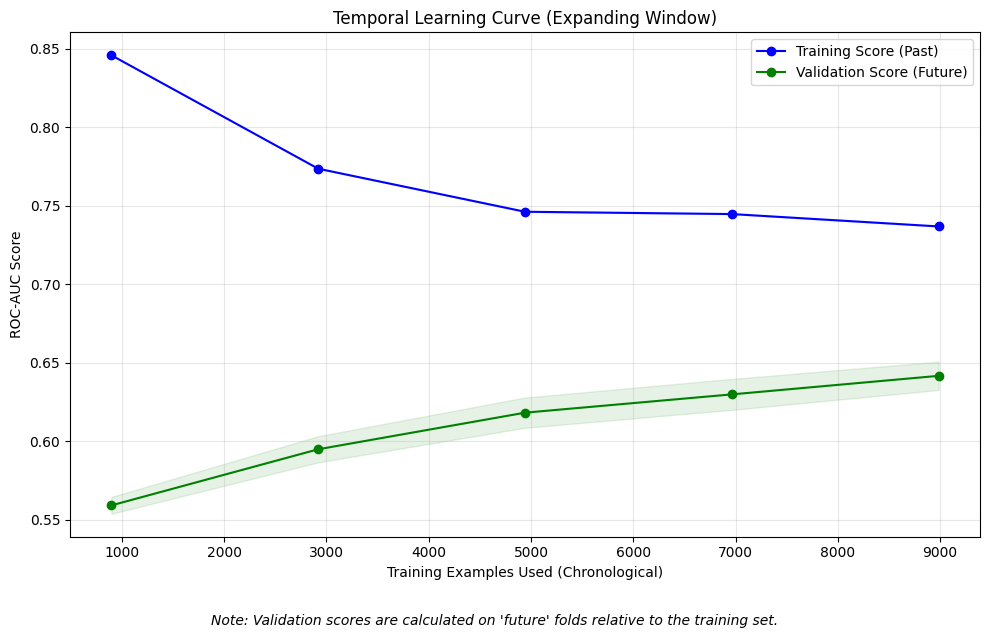

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve, TimeSeriesSplit
from sklearn.metrics import roc_auc_score

def check_logreg_overfitting_temporal(model, X_train, y_train, X_test, y_test):
    """
    1. Calculates the Generalization Gap (Train vs Future Test).
    2. Generates a Time-Aware Learning Curve using TimeSeriesSplit.
       This prevents 'looking ahead' into the future during validation.
    """

    # --- PART 1: THE NUMBERS (Train vs Future Test) ---
    print("--- 1. GENERALIZATION GAP (2000-2013 vs 2013-2015) ---")

    y_train_prob = model.predict_proba(X_train)[:, 1]
    y_test_prob = model.predict_proba(X_test)[:, 1]

    train_auc = roc_auc_score(y_train, y_train_prob)
    test_auc = roc_auc_score(y_test, y_test_prob)
    gap = train_auc - test_auc

    print(f"Train AUC (Past):   {train_auc:.4f}")
    print(f"Test AUC (Future):  {test_auc:.4f}")
    print(f"Gap:                {gap:.4f}")

    if gap > 0.10:
        print("Verdict:   ⚠️ HIGH OVERFITTING (Memorizing the past, failing the future)")
    elif gap > 0.05:
        print("Verdict:   ⚠️ MODERATE OVERFITTING")
    else:
        print("Verdict:   ✅ GOOD TEMPORAL GENERALIZATION")

    # --- PART 2: THE VISUAL (Time-Series Learning Curve) ---
    print("\n--- 2. GENERATING TEMPORAL LEARNING CURVE ---")
    print("(Using 5-Split Expanding Window: Train on Year 0-N, Validate on Year N+1)")

    # CRITICAL CHANGE: Use TimeSeriesSplit instead of standard CV
    # This ensures we never train on future data to predict the past
    tscv = TimeSeriesSplit(n_splits=5)

    train_sizes, train_scores, val_scores = learning_curve(
        model,
        X_train,
        y_train,
        cv=tscv,           # <--- The Fix: Enforce Time Order
        scoring='roc_auc',
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5),
        shuffle=False      # <--- The Fix: Do not shuffle rows
    )

    # Calculate means and standard deviations
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Plot
    plt.figure(figsize=(10, 6))

    # Plot Training Line
    plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training Score (Past)")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")

    # Plot Validation Line
    plt.plot(train_sizes, val_mean, 'o-', color="green", label="Validation Score (Future)")
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color="green")

    plt.title("Temporal Learning Curve (Expanding Window)")
    plt.xlabel("Training Examples Used (Chronological)")
    plt.ylabel("ROC-AUC Score")
    plt.legend(loc="best")
    plt.grid(True, alpha=0.3)

    # Add annotation explaining the split
    plt.figtext(0.5, -0.05, "Note: Validation scores are calculated on 'future' folds relative to the training set.",
                ha="center", fontsize=10, style='italic')

    plt.tight_layout()
    plt.show()

# --- EXECUTE ---
# Note: X_train must be sorted by date for this to work correctly.
# Your notebook sorted df by 'start_year' before splitting, so X_train is already sorted.
check_logreg_overfitting_temporal(model, X_train, y_train, X_test, y_test)

Running Deep Dive Analysis on Baseline Model...


/tmp/ipykernel_23875/325021978.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=slice_df, x='AUC', y='Slice', palette='viridis', ax=ax4)


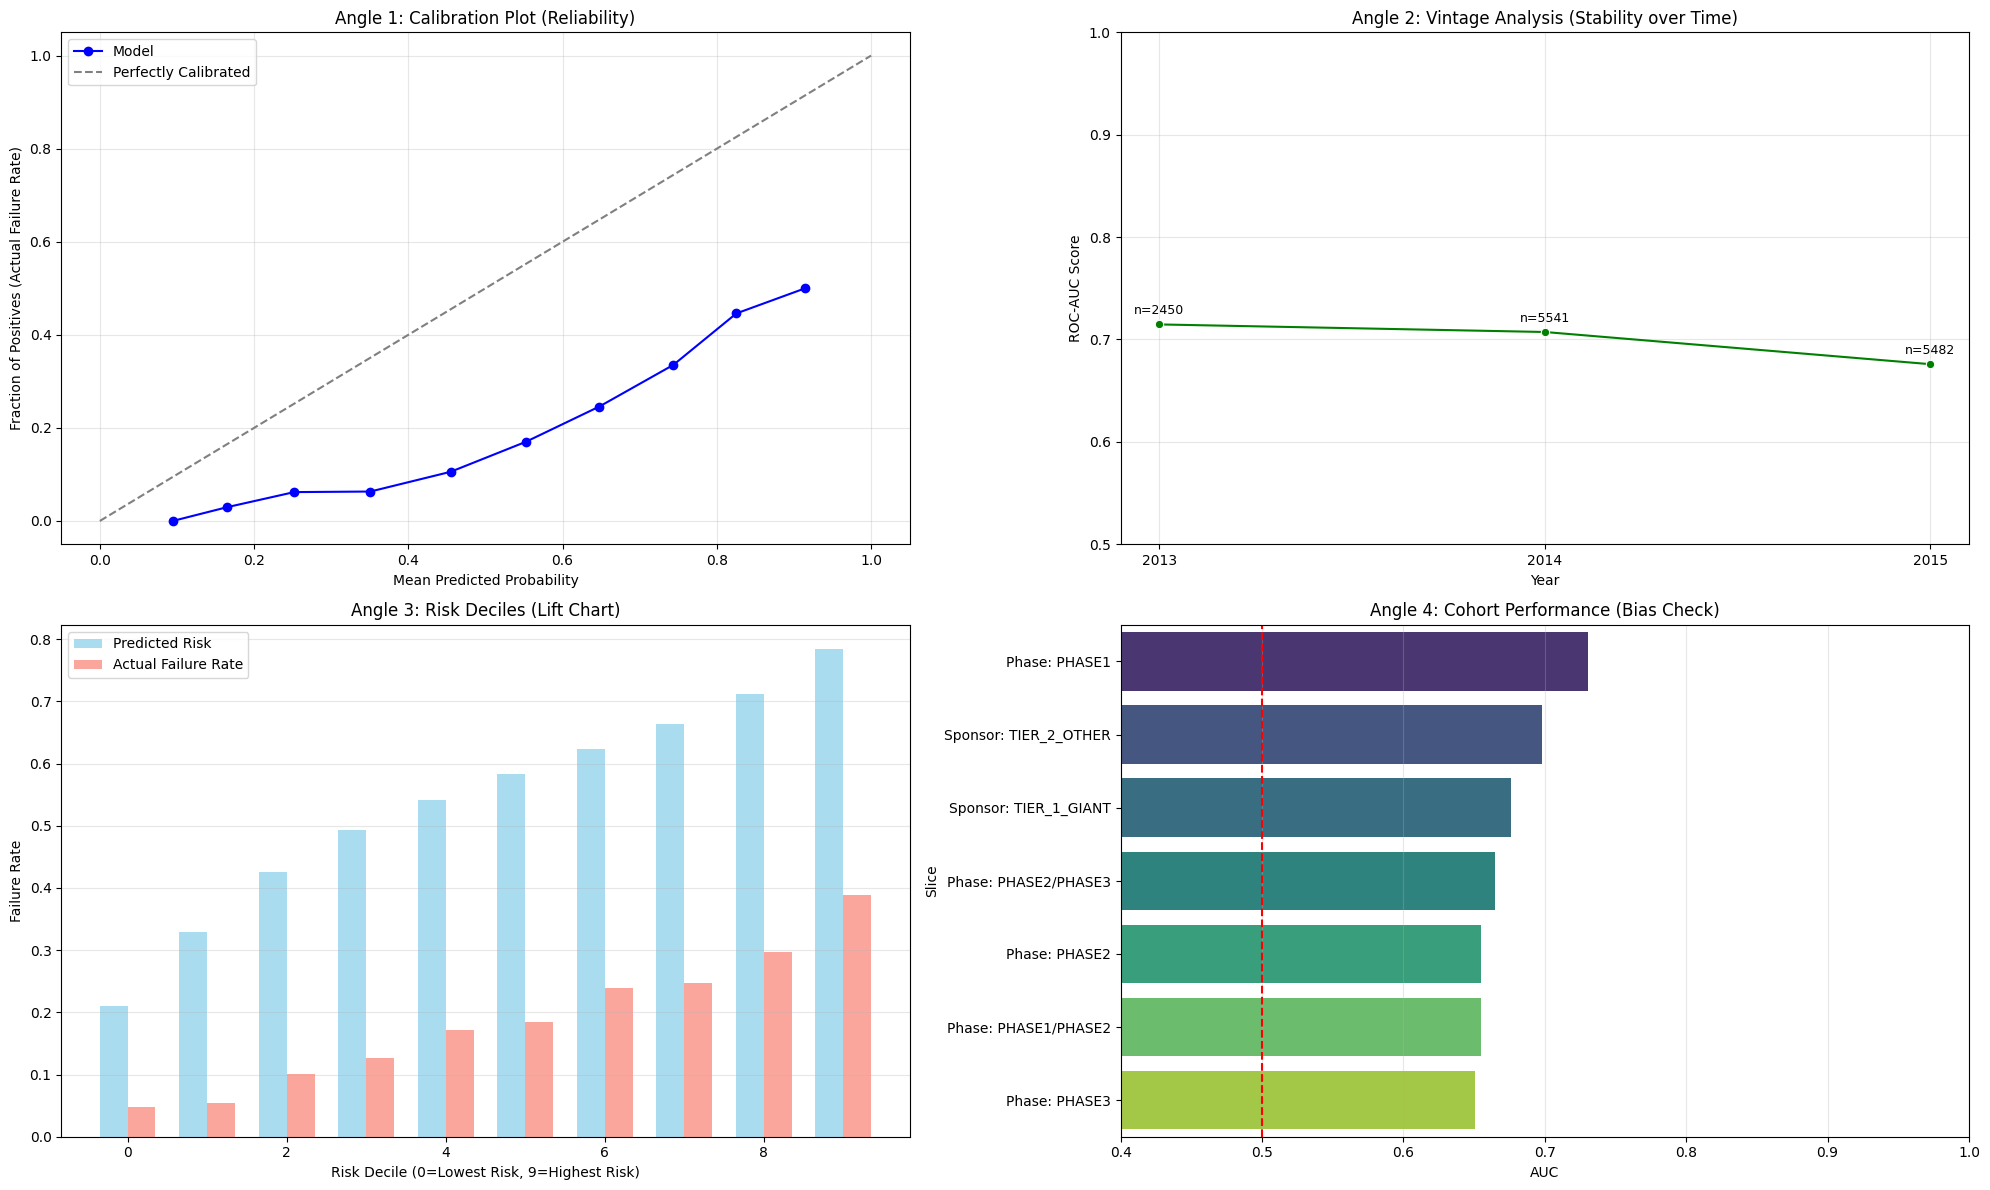

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score, precision_score, recall_score

def run_pro_analysis(model, X_test, y_test, raw_test_df):
    """
    Runs a 4-angle deep dive on model predictions.
    Requires:
    - model: Trained pipeline/model
    - X_test: Processed features (or raw if pipeline handles it)
    - y_test: Target labels
    - raw_test_df: The original dataframe for the test set (to extract Year/Phase/etc.)
    """

    # 1. Get Probabilities
    # Note: We take the probability of Class 1 (Failure)
    y_probs = model.predict_proba(X_test)[:, 1]

    # Create a temporary analysis dataframe
    analysis_df = raw_test_df.copy().reset_index(drop=True)
    analysis_df['target'] = y_test.values
    analysis_df['prob_failure'] = y_probs

    # Setup Plotting Grid
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    plt.subplots_adjust(hspace=0.3)

    # ==============================================================================
    # ANGLE 1: CALIBRATION CURVE (Reliability)
    # ==============================================================================
    prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10)
    ax1 = axes[0, 0]
    ax1.plot(prob_pred, prob_true, marker='o', label='Model', color='blue')
    ax1.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
    ax1.set_xlabel('Mean Predicted Probability')
    ax1.set_ylabel('Fraction of Positives (Actual Failure Rate)')
    ax1.set_title('Angle 1: Calibration Plot (Reliability)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # ==============================================================================
    # ANGLE 2: VINTAGE ANALYSIS (Temporal Stability)
    # ==============================================================================
    # Group by Start Year and calculate AUC per year
    vintage_stats = []
    years = sorted(analysis_df['start_year'].unique())

    for year in years:
        subset = analysis_df[analysis_df['start_year'] == year]
        if len(subset) > 0 and subset['target'].nunique() > 1:
            auc = roc_auc_score(subset['target'], subset['prob_failure'])
            count = len(subset)
            vintage_stats.append({'Year': int(year), 'AUC': auc, 'Count': count})

    vintage_df = pd.DataFrame(vintage_stats)

    ax2 = axes[0, 1]
    sns.lineplot(data=vintage_df, x='Year', y='AUC', marker='o', color='green', ax=ax2)
    ax2.set_ylim(0.5, 1.0)
    ax2.set_title('Angle 2: Vintage Analysis (Stability over Time)')
    ax2.set_ylabel('ROC-AUC Score')
    ax2.set_xticks(vintage_df['Year'])
    ax2.grid(True, alpha=0.3)

    # Add count labels
    for index, row in vintage_df.iterrows():
        ax2.text(row['Year'], row['AUC'] + 0.01, f"n={int(row['Count'])}", ha='center', fontsize=9)

    # ==============================================================================
    # ANGLE 3: RISK DECILE ANALYSIS (Business Impact)
    # ==============================================================================
    # Bin predictions into 10 buckets (Deciles)
    analysis_df['decile'] = pd.qcut(analysis_df['prob_failure'], 10, labels=False, duplicates='drop')

    decile_stats = analysis_df.groupby('decile').agg({
        'target': 'mean',          # Actual Failure Rate
        'prob_failure': 'mean'     # Predicted Failure Rate
    }).reset_index()

    ax3 = axes[1, 0]
    width = 0.35
    x = np.arange(len(decile_stats))

    ax3.bar(x - width/2, decile_stats['prob_failure'], width, label='Predicted Risk', color='skyblue', alpha=0.7)
    ax3.bar(x + width/2, decile_stats['target'], width, label='Actual Failure Rate', color='salmon', alpha=0.7)

    ax3.set_xlabel('Risk Decile (0=Lowest Risk, 9=Highest Risk)')
    ax3.set_ylabel('Failure Rate')
    ax3.set_title('Angle 3: Risk Deciles (Lift Chart)')
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)

    # ==============================================================================
    # ANGLE 4: COHORT SLICING (Phase & Sponsor)
    # ==============================================================================
    # Calculate AUC for specific slices
    slices = []

    # Slice by Phase
    for phase in analysis_df['phase'].unique():
        subset = analysis_df[analysis_df['phase'] == phase]
        if len(subset) > 50 and subset['target'].nunique() > 1:
            auc = roc_auc_score(subset['target'], subset['prob_failure'])
            slices.append({'Slice': f"Phase: {phase}", 'AUC': auc})

    # Slice by Sponsor Tier
    for tier in analysis_df['sponsor_tier'].unique():
        subset = analysis_df[analysis_df['sponsor_tier'] == tier]
        if len(subset) > 50 and subset['target'].nunique() > 1:
            auc = roc_auc_score(subset['target'], subset['prob_failure'])
            slices.append({'Slice': f"Sponsor: {tier}", 'AUC': auc})

    slice_df = pd.DataFrame(slices).sort_values('AUC', ascending=False)

    ax4 = axes[1, 1]
    sns.barplot(data=slice_df, x='AUC', y='Slice', palette='viridis', ax=ax4)
    ax4.set_xlim(0.4, 1.0)
    ax4.set_title('Angle 4: Cohort Performance (Bias Check)')
    ax4.axvline(0.5, color='red', linestyle='--', label='Random')
    ax4.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.show()

    return analysis_df

# ---------------------------------------------------------
# EXECUTE ANALYSIS
# ---------------------------------------------------------
# Ensure we pass the raw test dataframe to get columns like 'start_year' and 'phase' back
# We use test_df (which you defined in cell 11 of your notebook)
print("Running Deep Dive Analysis on Baseline Model...")
results_df = run_pro_analysis(model, X_test, y_test, test_df)

In [12]:
# 1. Instantiate the Preprocessor
preprocessor = get_pipeline()

# 2. Fit and Transform X_train
# CRITICAL FIX: Pass y_train here! TargetEncoder needs it.
print("Running preprocessor... this might take a moment due to SVD...")
X_train_transformed = preprocessor.fit_transform(X_train, y_train)

# --- FIX FOR SPARSE MATRICES ---
if hasattr(X_train_transformed, "toarray"):
    X_train_transformed = X_train_transformed.toarray()

# 3. Get Feature Names
feature_names = preprocessor.get_feature_names_out()

# 4. Convert to DataFrame for Easy Viewing
df_transformed = pd.DataFrame(
    X_train_transformed,
    columns=feature_names,
    index=X_train.index
)

# --- INSPECTION REPORT ---
print(f"\nOriginal Shape: {X_train.shape}")
print(f"Transformed Shape: {df_transformed.shape}")
print("-" * 50)

# 5. Inspect SVD Columns
svd_cols = [col for col in df_transformed.columns if 'svd' in col.lower()]
if svd_cols:
    print(f"\n✅ Found {len(svd_cols)} Text SVD Features")
    print(df_transformed[svd_cols[:5]].head(3))
else:
    print("\n❌ Could not identify SVD columns by name.")

# 6. Show Head
print("\nFirst 5 rows of transformed data:")
try:
    display(df_transformed.head())
except:
    print(df_transformed.head())

Running preprocessor... this might take a moment due to SVD...

Original Shape: (53890, 133)
Transformed Shape: (53890, 232)
--------------------------------------------------

✅ Found 50 Text SVD Features
   truncatedsvd0  truncatedsvd1  truncatedsvd2  truncatedsvd3  truncatedsvd4
0       0.004077      -0.000259       0.007047      -0.001795       0.012523
1       0.026969      -0.006416       0.035326      -0.003815       0.029236
2       0.055235      -0.037177       0.090035       0.021284      -0.054122

First 5 rows of transformed data:


,competition_niche,competition_broad,num_primary_endpoints,number_of_arms,criteria_len_log,start_year,phase_ordinal,is_international_1,covid_exposure_0,healthy_volunteers_No,...,emb_90,emb_91,emb_92,emb_93,emb_94,emb_95,emb_96,emb_97,emb_98,emb_99
0,-2.283749,-3.109675,-0.466955,-0.020944,-0.190735,-2.275656,0.5,0.0,1.0,0.0,...,0.908117,-0.905456,-0.142532,1.440077,-1.073659,-0.854476,-1.370227,0.178977,-0.484826,0.535013
1,0.033433,-0.267331,-0.466955,-0.020944,1.049087,-2.275656,0.5,1.0,1.0,0.0,...,-1.251257,-0.624796,0.005519,-0.160898,0.582276,0.994090,1.204923,0.138092,-0.801181,0.963543
2,0.033433,-0.267331,-0.466955,-1.213431,0.570151,-2.275656,0.5,1.0,1.0,0.0,...,-0.306918,0.424291,0.108232,-0.460687,-0.326714,0.973457,2.281015,0.962982,0.928476,0.936523
3,0.033433,-0.267331,-0.466955,-0.020944,0.578480,-2.275656,0.5,0.0,1.0,0.0,...,-1.817638,1.252767,-1.181931,1.646044,0.623042,1.220381,-0.964362,-0.725996,-1.453708,-0.765897
4,-0.752214,-1.758045,2.354354,0.825140,0.394939,-2.275656,0.0,0.0,1.0,0.0,...,0.115551,0.165597,-0.479978,-1.516782,0.783246,-1.167434,0.263750,-0.007577,-0.926272,-1.766254
